In [1]:
# On importe les librairies dont on aura besoin pour ce travail
import pandas as pd
import matplotlib.patches as mpatches
from matplotlib import pyplot as plt, cm as cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing

In [2]:
# Référence en y du plot
_ORDONNEE = "nutrition-score-fr_100g"

# Lieu où se trouve le FICHIER
_FICHIER = 'C:\\Users\\Toni\\Desktop\\pas_synchro\\bdd_clean.csv'

Fonction qui permet d'afficher un graphique où l'on verra l'importance relative de chaque élément dans le calcul final

In [3]:
def definir_importance(data):

    # Log
    print("Fct definir_importance : \n")

    # Trouver le numéro de colonne qui nous sert d'ordonné dans l'affichage
    position_ordonne = data.columns.get_loc(_ORDONNEE)

    # Isolate Data, class labels and column values
    #X = data.iloc[:,0:15]       # colonne 0 à 15
    xdata = data.iloc[:, 0:position_ordonne]    # toutes les colonnes sauf la dernière
    ydata = data.iloc[:, position_ordonne]      # dernière colonne

    # names = data.columns.values[0:15]                 # avec limite
    names = data.columns.values[0:position_ordonne]     # sans limite

    # Build the model
    rfc = RandomForestClassifier(n_estimators=100, criterion='gini', verbose=1)

    # Fit the model
    rfc.fit(xdata, ydata)

    # Print the results
    #print("Features sorted by their score:")
    #print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), names), reverse = True))

    # Isolate feature importances
    importance = rfc.feature_importances_

    # Sort the feature importances
    sorted_importances = np.argsort(importance)

    # Insert padding
    padding = np.arange(len(names)) + 0.5

    # Customize the plot
    plt.yticks(padding, names[sorted_importances])
    plt.xlabel("Relative Importance")
    plt.title("Variable Importance")

    # Plot the data
    plt.barh(padding, importance[sorted_importances], align='center')

    # Show the plot
    plt.show()

Fonction qui permet de créer une visualisation du lien entre les variables 2 à 2

In [4]:
def correlation_matrix(data):

    # Calcul de la matrice
    corr = data.corr()
    cmap = cm.get_cmap('jet', 30)

    # Taille de la figure
    plt.figure(figsize=(10, 10))
    # Création du type d'image
    cax = plt.imshow(data.corr(), interpolation="nearest", cmap=cmap)
    plt.grid(True)

    # Libellés sur les axes
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)

    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    plt.colorbar(cax, ticks=[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1])
    plt.show()

On entre dans le main

In [5]:
# On charge le dataset sur les colonnes qui nous ont intéressés dans la fonction du dessus
data = pd.read_csv(_FICHIER,
                   error_bad_lines=False,
                   engine='python',
                   sep=',')

# On supprime une colonne inutile
del data['Unnamed: 0']

Fct definir_importance : 



[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   32.4s finished


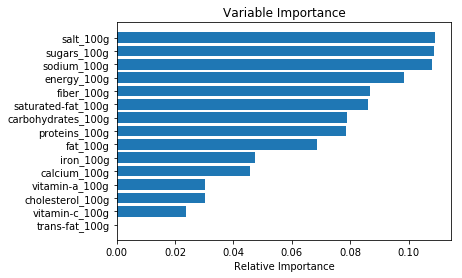

In [6]:
# Création de la matrice d'importance
definir_importance(data)

Ce diagramme permet de voir directement quels sont les variables qui sont les plus importantes dans le calcul final du score nutritionnel. Dans l’ordre, les 5 variables *plus importantes* sont :

* La quantité de sucre
* La quantité de sel
* La quantité de sodium
* La quantité d’énergie
* La quantité de fibres

Autrement dit, plus il y a de sucres (ou de sel, ou de sodium, etc…) plus la qualité du produit va être impactée. 

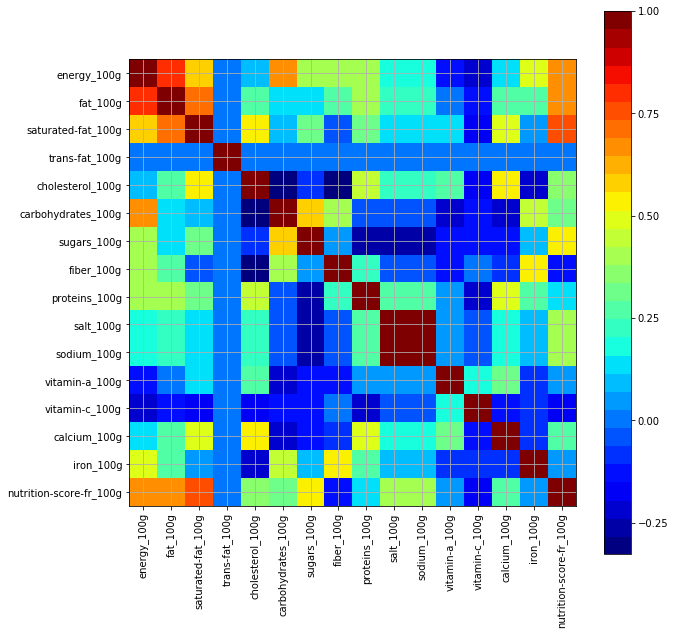

In [7]:
# Création du collérogramme
correlation_matrix(data)

Dans le corrélogramme, il ne faut pas prendre en compte la diagonale (supérieure gauche-inférieure droite) car elle « montre l’impact d’une variable sur elle-même ». Sa valeur sera toujours de 1.

Les conclusions essentielles à tirer de cette figure sont les suivantes :

__Sont très liées :__
* Les quantités d’énergie et de graisse.
* Les quantités de graisse et de graisses saturées.
* Les quantités de carbohydrates et d’énergie.

__Vont faire progresser positivement le score nutritionnel :__
* La quantité de vitamine A.
* La quantité de vitamine C.
* La quantité de fibres
* La quantité de protéines.

__Vont faire progresser négativement le score nutritionnel :__
* La quantité d’énergie
* La quantité de graisse.
* La quantité de sucre.
* La quantité de graisse saturée.

On va maintenant essayer de créer quelques variables afin de simplifier la lecture immédiate de certains résultats

In [8]:
# Variables tableaux qui vont être utilisées
results = []

# Taille de l'abscisse
array_x_plot = np.arange(10.0, 350.0, 2)

Dans les lignes ci-dessous, on arrange des nouvelles colonnes sur une base copiée, pour ne pas polluer l'originale

In [9]:
# Copy de la database initial pour ne pas travailler dessus directement
df = data.copy()

# Suppresion de la colonne non-chiffre
del df['nutrition_grade_fr']

# On va scaler les données pour les prochaines colonnes créées
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.values)
df2 = pd.DataFrame(x_scaled)

# On recopie les noms des colonnes
df2.columns = df.columns

# Calculs
# Somme des élments positifs
df2['Positif'] = df2['vitamin-a_100g']+df2['vitamin-c_100g']+df2['fiber_100g']+df2['proteins_100g']+df2['iron_100g']

# Somme des éléments négatifs
df2['Negatif'] = df2['sugars_100g']+df2['salt_100g']+df2['energy_100g']+df2['saturated-fat_100g']

# Différence du résultat
df2['Diff'] = (0.01+df2['Positif'])/(0.01+df2['Negatif'])

Dans la partie ci-dessous, nous allons essayer de "valider" les similitudes entre l'échelle créé ici et l'echelle du nutriscore. Nous allons rechercher une valeur "i" qui va maximiser le taux de similitude, sans toutefois chercher à l'atteindre.

Le but ici est uniquement de donner un aperçu ce qui pourrait être fait dans un futur projet

In [10]:
# de i=1 à i+200 avec i=i+1
for i in array_x_plot:

    # On fait une boucle pour faire les 3 à la suite
    nom_colonne = ['Positif', 'Negatif', 'Diff']
    choices = ['e', 'd', 'c', 'b', 'a']

    for colonne in nom_colonne:
        # Valeur max de la colonne
        value_max = df2[colonne].max()

        # On divise en 5 subsets
        conditions = [
            (df2[colonne] <= (1/i)*(value_max)),
            (df2[colonne] > (1/i)*(value_max)) & (df2[colonne] <= (2/i)*(value_max)),
            (df2[colonne] > (2/i)*(value_max)) & (df2[colonne] <= (3/i)*(value_max)),
            (df2[colonne] > (3/i)*(value_max)) & (df2[colonne] <= (4/i)*(value_max)),
            (df2[colonne] > (4/i)*(value_max))]

        # On rajoute la colonne avec la donnée
        colonne_cible = 'Indice' + colonne[0]
        df2[colonne_cible] = np.select(conditions, choices)

    # On recopie une colonne de l'autre dataset
    df['Qualite'] = df2['IndiceD']

    # Rajout de la colonne du nutri score en lettres
    df['nutrition_grade_fr'] = data['nutrition_grade_fr']

    # Rajout d'une colonne qui est True/False si les valeurs sont égales
    df['Verdict'] = df['Qualite'] == df['nutrition_grade_fr']

    # Nom de la colonne de référence
    ref = 'nutrition_grade_fr'

    # Calcul des scores
    score = 100 * df['Verdict'].where(df['Verdict']).count()/df['Verdict'].count()
    results.append(score)

__Affichage des résultats en fonction de la valeur de i__

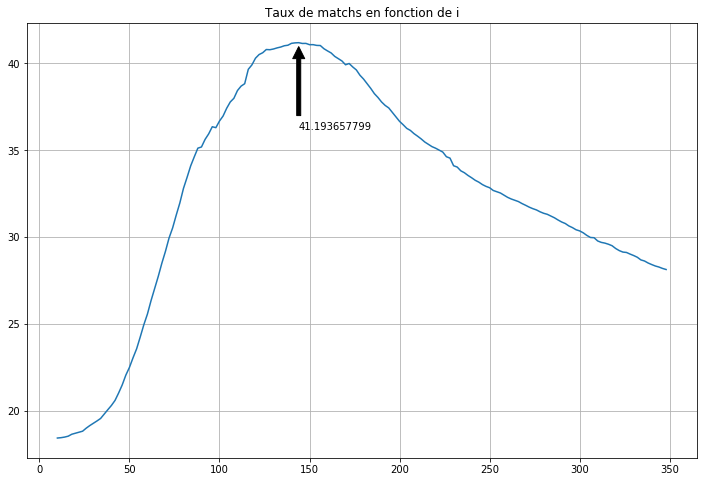

In [11]:
plt.figure(figsize=(12, 8))
plt.title('Taux de matchs en fonction de i')
plt.plot(array_x_plot, results)

# Affichage du max
ymax = max(results)
xpos = results.index(ymax)
xmax = array_x_plot[xpos]
plt.annotate(ymax, xy=(xmax, ymax), xytext=(xmax, ymax-5), arrowprops=dict(facecolor='black', shrink=0.05))

plt.grid('on')
plt.show()

On peut obtenir un taux de 41,19 % de ressemblance entre les deux échelles.

__Créons maintenant un diagramme de type camembert pour voir la répartion entre les bons et les mauvais aliments, suivant les échelles créés ici.__

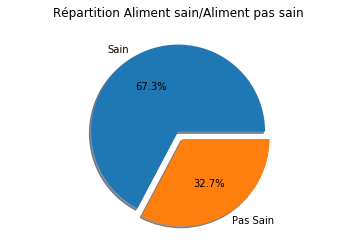

In [12]:
# Dictionnaire pour décider des bons aliments ou pas
dico = {'a': True, 'b': True, 'c' : False, 'd' : False, 'e' : False}

# Rajout d'une colonne qui est True/False si les aliments sont sains
df['Aliment Sain'] = df['Qualite'].map(dico)

# Visualisation via un camembert
data_pie_1 = df['Aliment Sain'].where(df['Aliment Sain']).count()
data_pie_2 = df['Aliment Sain'].where(df['Aliment Sain'] == False).count()
data_pie = [data_pie_1, data_pie_2]
plt.axis('equal')
plt.title('Répartition Aliment sain/Aliment pas sain')
plt.pie(data_pie, labels=['Sain', 'Pas Sain'], shadow = True, explode = [0, 0.1], autopct='%1.1f%%')
plt.show()

Si on considère que les aliments 'a' et 'b' sont sains, on obtient les 2/3 des aliments sains.

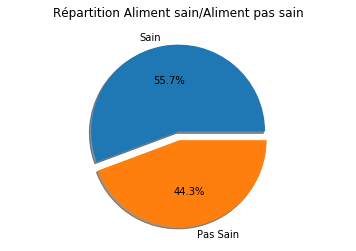

In [13]:
# Dictionnaire pour décider des bons aliments ou pas
dico = {'a': True, 'b': False, 'c' : False, 'd' : False, 'e' : False}

# Rajout d'une colonne qui est True/False si les aliments sont sains
df['Aliment Sain'] = df['Qualite'].map(dico)

# Visualisation via un camembert
data_pie_1 = df['Aliment Sain'].where(df['Aliment Sain']).count()
data_pie_2 = df['Aliment Sain'].where(df['Aliment Sain'] == False).count()
data_pie = [data_pie_1, data_pie_2]
plt.axis('equal')
plt.title('Répartition Aliment sain/Aliment pas sain')
plt.pie(data_pie, labels=['Sain', 'Pas Sain'], shadow = True, explode = [0, 0.1], autopct='%1.1f%%')
plt.show()

Avec uniquement les aliments 'a', on arrive à 56 %

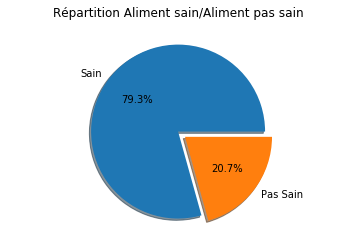

In [14]:
# Dictionnaire pour décider des bons aliments ou pas
dico = {'a': True, 'b': True, 'c' : True, 'd' : False, 'e' : False}

# Rajout d'une colonne qui est True/False si les aliments sont sains
df['Aliment Sain'] = df['Qualite'].map(dico)

# Visualisation via un camembert
data_pie_1 = df['Aliment Sain'].where(df['Aliment Sain']).count()
data_pie_2 = df['Aliment Sain'].where(df['Aliment Sain'] == False).count()
data_pie = [data_pie_1, data_pie_2]
plt.axis('equal')
plt.title('Répartition Aliment sain/Aliment pas sain')
plt.pie(data_pie, labels=['Sain', 'Pas Sain'], shadow = True, explode = [0, 0.1], autopct='%1.1f%%')
plt.show()

Enfin, avec les aliments 'a', 'b' et 'c' on arrive à 79,3 %